In [22]:
import os
from pathlib import Path
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint


from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, mean_absolute_error
from sklearn.model_selection import train_test_split

In [2]:
RND = 42
np.random.seed(RND)

In [3]:
BASE = Path('.')

def find_files(patterns):
    files = []
    for p in patterns:
        files.extend(map(Path, glob.glob(str(BASE / p), recursive=True)))
    return sorted(files)

In [4]:
gt_candidates = find_files(["**/gt_*.csv", "**/3_*gt*.csv", "**/3_gas*/*.csv"]) # gas turbine files
prsa_candidates = find_files(["**/PRSA_Data_*.csv", "**/2_*PRSA*/*.csv", "**/PRSA_data/**/*.csv"]) # Beijing
arff_candidates = find_files(["**/*.arff", "**/Autism*/*.arff"]) # autism


print(f'Found {len(gt_candidates)} gas turbine candidate files')
print(f'Found {len(prsa_candidates)} PRSA (Beijing) candidate files')
print(f'Found {len(arff_candidates)} ARFF candidate files')

Found 10 gas turbine candidate files
Found 24 PRSA (Beijing) candidate files
Found 1 ARFF candidate files


In [5]:
def load_gas_turbine():
    if not gt_candidates:
        raise FileNotFoundError('No gas turbine files found. Put gt_2011.csv .. gt_2015.csv under datasets folder.')
    df_list = []
    for f in gt_candidates:
        df = pd.read_csv(f)
        # try to detect a year column or filename year
        df['_source_file'] = f.name
        df_list.append(df)
    # sort by filename (should be chronological if file names contain years)
    all_df = pd.concat(df_list, ignore_index=True)
    print('Gas turbine columns:')
    pprint(list(all_df.columns))
    return all_df

In [6]:
def load_prsa_all():
    if not prsa_candidates:
        raise FileNotFoundError('No PRSA CSVs found. Put PRSA_Data_*.csv files under datasets/2_...')
    stations = {}
    for f in prsa_candidates:
        name = f.stem # PRSA_Data_Aotizhongxin_20130101-20151231
        # extract station name between PRSA_Data_ and first _20 or end
        parts = name.split('_')
        station = '_'.join(parts[2:-1]) if len(parts) > 3 else parts[2] if len(parts)>2 else name
        try:
            df = pd.read_csv(f)
        except Exception as e:
            print('Failed reading', f, e)
            continue
        stations[station] = df
    print('Loaded stations:', list(stations.keys())[:10])
    return stations

In [7]:
# Autism ARFF loader (without liac_arff)
def load_arff(path):
    try:
        from scipy.io import arff
        data, meta = arff.loadarff(str(path))
        df = pd.DataFrame(data)
        # decode bytes columns if necessary
        for c in df.select_dtypes([object]).columns:
            try:
                df[c] = df[c].str.decode('utf-8')
            except Exception:
                pass
        print('Loaded ARFF with columns:', list(df.columns))
        return df
    except Exception as e:
        print('scipy.io.arff failed:', e)

    # fallback: simple manual parsing
    lines = []
    with open(path, 'r', encoding='utf-8', errors='ignore') as fh:
        for line in fh:
            if line.strip().startswith('@'):  # skip metadata lines
                continue
            lines.append(line)

    try:
        from io import StringIO
        df = pd.read_csv(StringIO(''.join(lines)))
        print('Fallback ARFF parsed, columns:', list(df.columns))
        return df
    except Exception as e:
        raise RuntimeError('Failed to load ARFF with scipy or fallback: ' + str(e))


In [8]:
# Load data (only load what is found)

GT_DF = None
PRSA_DICT = {}
AUTISM_DF = None

if gt_candidates:
    GT_DF = load_gas_turbine()
if prsa_candidates:
    PRSA_DICT = load_prsa_all()
if arff_candidates:
    AUTISM_DF = load_arff(arff_candidates[0])

# Show small previews
if GT_DF is not None:
    print('\nGas turbine preview:')
    display(GT_DF.head())
if PRSA_DICT:
    k = list(PRSA_DICT.keys())[0]
    print(f'\nPRSA station sample ({k}) preview:')
    display(PRSA_DICT[k].head())
if AUTISM_DF is not None:
    print('\nAutism preview:')
    display(AUTISM_DF.head())


Gas turbine columns:
['AT',
 'AP',
 'AH',
 'AFDP',
 'GTEP',
 'TIT',
 'TAT',
 'TEY',
 'CDP',
 'CO',
 'NOX',
 '_source_file']


Loaded stations: ['Aotizhongxin', 'Changping', 'Dingling', 'Dongsi', 'Guanyuan', 'Gucheng', 'Huairou', 'Nongzhanguan', 'Shunyi', 'Tiantan']
Loaded ARFF with columns: ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender', 'ethnicity', 'jundice', 'austim', 'contry_of_res', 'used_app_before', 'result', 'age_desc', 'relation', 'Class/ASD']

Gas turbine preview:


,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX,_source_file
0,4.5878,1018.7,83.675,3.5758,23.979,1086.2,549.83,134.67,11.898,0.32663,81.952,gt_2011.csv
1,4.2932,1018.3,84.235,3.5709,23.951,1086.1,550.05,134.67,11.892,0.44784,82.377,gt_2011.csv
2,3.9045,1018.4,84.858,3.5828,23.990,1086.5,550.19,135.10,12.042,0.45144,83.776,gt_2011.csv
3,3.7436,1018.3,85.434,3.5808,23.911,1086.5,550.17,135.03,11.990,0.23107,82.505,gt_2011.csv
4,3.7516,1017.8,85.182,3.5781,23.917,1085.9,550.00,134.67,11.910,0.26747,82.028,gt_2011.csv



PRSA station sample (Aotizhongxin) preview:


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin



Autism preview:


,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,1,1,0,0,1,1,0,0,...,f,White-European,no,no,United States,no,6.0,18 and more,Self,NO
1,1,1,0,1,0,0,0,1,0,1,...,m,Latino,no,yes,Brazil,no,5.0,18 and more,Self,NO
2,1,1,0,1,1,0,1,1,1,1,...,m,Latino,yes,yes,Spain,no,8.0,18 and more,Parent,YES
3,1,1,0,1,0,0,1,1,0,1,...,f,White-European,no,yes,United States,no,6.0,18 and more,Self,NO
4,1,0,0,0,0,0,0,1,0,0,...,f,?,no,no,Egypt,no,2.0,18 and more,?,NO


In [9]:
def introduce_mcar_per_feature(df, missing_fraction, exclude_cols=None, copy=True):
    """Delete missing_fraction of values in each column independently (MCAR as in paper)."""
    if copy:
        df_m = df.copy()
    else:
        df_m = df
    exclude_cols = exclude_cols or []
    mask = pd.DataFrame(False, index=df.index, columns=df.columns)
    for c in df.columns:
        if c in exclude_cols:
            continue
        col = df_m[c]
        n = len(col)
        k = int(np.floor(missing_fraction * n))
        if k <= 0:
            continue
        idx = np.random.choice(df.index, size=k, replace=False)
        df_m.loc[idx, c] = np.nan
        mask.loc[idx, c] = True
    return df_m, mask


def introduce_mnar_threshold(df, threshold=0.95, exclude_cols=None, add_random_frac=0.01, copy=True):
    """Introduce MNAR by setting values > threshold (on min-max normalized columns) to NaN."""
    if copy:
        df_m = df.copy()
    else:
        df_m = df
    exclude_cols = exclude_cols or []
    mask = pd.DataFrame(False, index=df.index, columns=df.columns)

    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    for c in num_cols:
        if c in exclude_cols:
            continue
        col = df[c]
        if col.dropna().empty:
            continue
        mn = col.min()
        mx = col.max()
        if pd.isna(mn) or pd.isna(mx) or mx == mn:
            continue
        scaled = (col - mn) / (mx - mn)
        to_delete = scaled > threshold
        if to_delete.any():
            df_m.loc[to_delete, c] = np.nan
            mask.loc[to_delete, c] = True

    if add_random_frac and add_random_frac > 0:
        n_total = df.size
        k = int(np.floor(add_random_frac * n_total))
        if k > 0:
            rows = np.random.choice(df.index, size=k, replace=True)
            cols = np.random.choice(df.columns, size=k, replace=True)
            for r, c in zip(rows, cols):
                if c in exclude_cols:
                    continue
                df_m.at[r, c] = np.nan
                mask.at[r, c] = True
    return df_m, mask


In [10]:
def apply_imputation(df_missing, method='mean', k=5):
    """Return DataFrame imputed (numeric imputation only)."""
    numeric_cols = df_missing.select_dtypes(include=[np.number]).columns.tolist()
    nonnum_cols = [c for c in df_missing.columns if c not in numeric_cols]
    X_num = df_missing[numeric_cols]
    if method == 'mean':
        imp = SimpleImputer(strategy='mean')
    elif method == 'median':
        imp = SimpleImputer(strategy='median')
    elif method == 'most_frequent':
        imp = SimpleImputer(strategy='most_frequent')
    elif method == 'knn':
        imp = KNNImputer(n_neighbors=k)
    else:
        raise ValueError('Unknown method')
    X_imp = pd.DataFrame(imp.fit_transform(X_num), columns=numeric_cols, index=df_missing.index)
    if nonnum_cols:
        for c in nonnum_cols:
            X_imp[c] = df_missing[c]
    X_imp = X_imp[df_missing.columns]
    return X_imp


In [11]:
def imputation_metrics(original_scaled, imputed_scaled, mask):
    """Compute MAE, L10, L25 between imputed and original values (on normalized scale)."""
    assert original_scaled.shape == imputed_scaled.shape == mask.shape
    num_cols = original_scaled.select_dtypes(include=[np.number]).columns
    orig = original_scaled[num_cols].to_numpy(dtype=float)
    imp = imputed_scaled[num_cols].to_numpy(dtype=float)
    m = mask[num_cols].to_numpy(dtype=bool)
    if not m.any():
        return np.nan, np.nan, np.nan
    abs_err = np.abs(orig - imp)
    masked_err = abs_err[m]
    mae = masked_err.mean()
    L10 = 100.0 * np.mean(masked_err < 0.1)
    L25 = 100.0 * np.mean(masked_err < 0.25)
    return mae, L10, L25


In [12]:
def train_evaluate_regression(X_train, y_train, X_test, y_test, model_name='mlp'):
    """Train model and return MSE. model_name: 'mlp', 'svr_rbf', 'svr_lin'."""
    if model_name == 'mlp':
        model = MLPRegressor(hidden_layer_sizes=(8,8,8,8,8), max_iter=1000, random_state=RND)
    elif model_name == 'svr_rbf':
        model = SVR(kernel='rbf')
    elif model_name == 'svr_lin':
        model = SVR(kernel='linear')
    else:
        raise ValueError('unknown model')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

In [13]:
def train_evaluate_classification(X_train, y_train, X_test, y_test, model_name='svc'):
    """Train classifier and return ROC-AUC + ROC curve."""
    if model_name == 'svc':
        model = SVC(probability=True, kernel='rbf', random_state=RND)
    elif model_name == 'mlp':
        model = MLPClassifier(hidden_layer_sizes=(32,16,8), max_iter=1000, random_state=RND)
    else:
        raise ValueError('unknown model')
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, probs)
    fpr, tpr, _ = roc_curve(y_test, probs)
    return auc, fpr, tpr


In [14]:
def gas_turbine_experiments(GT_DF):
    # detect targets (CO, NOx)
    num_cols = GT_DF.select_dtypes(include=[np.number]).columns.tolist()
    target_co, target_nox = num_cols[-2], num_cols[-1]  # fallback
    features = [c for c in num_cols if c not in (target_co, target_nox)]
    print('Detected targets (CO, NOx):', target_co, target_nox)

    # chronological split
    GT_DF_sorted = GT_DF.reset_index(drop=True)
    n = len(GT_DF_sorted)
    train_mask = GT_DF_sorted.index < int(0.6*n)
    val_mask = (GT_DF_sorted.index >= int(0.6*n)) & (GT_DF_sorted.index < int(0.8*n))
    test_mask = GT_DF_sorted.index >= int(0.8*n)
    train_df = GT_DF_sorted.loc[train_mask]
    test_df  = GT_DF_sorted.loc[test_mask]

    scaler = MinMaxScaler().fit(train_df[features])

    fractions = [0.01,0.02,0.05,0.10,0.20,0.50,0.67,0.75]
    results_mae, results_L10, results_L25 = {}, {}, {}
    results_mse_nox, results_mse_co = {}, {}

    for frac in fractions:
        print(f'\n--- Missing fraction {frac} ---')
        train_missing, mask = introduce_mcar_per_feature(train_df[features], missing_fraction=frac)
        for label, method in [('mean','mean'), ('median','median'),
                              ('knn3',('knn',3)), ('knn5',('knn',5)), ('knn10',('knn',10))]:
            if isinstance(method, tuple):
                imputed = apply_imputation(train_missing, method='knn', k=method[1])
            else:
                imputed = apply_imputation(train_missing, method=method)
            # metrics
            orig_scaled = pd.DataFrame(scaler.transform(train_df[features]), columns=features)
            imp_scaled  = pd.DataFrame(scaler.transform(imputed[features]), columns=features)
            mae, L10, L25 = imputation_metrics(orig_scaled, imp_scaled, mask)
            results_mae.setdefault(label, []).append(mae)
            results_L10.setdefault(label, []).append(L10)
            results_L25.setdefault(label, []).append(L25)
            # modeling
            X_train = scaler.transform(imputed[features])
            X_test  = scaler.transform(test_df[features])
            mse_nox = train_evaluate_regression(X_train, train_df[target_nox], X_test, test_df[target_nox])
            mse_co  = train_evaluate_regression(X_train, train_df[target_co],  X_test, test_df[target_co])
            results_mse_nox.setdefault(label, []).append(mse_nox)
            results_mse_co.setdefault(label, []).append(mse_co)
            print(f"{label}: MAE={mae:.4f} L10={L10:.1f} L25={L25:.1f} MSE_NOx={mse_nox:.4f} MSE_CO={mse_co:.4f}")

    return {
        'fractions': fractions,
        'mae': pd.DataFrame(results_mae, index=[int(f*100) for f in fractions]),
        'L10': pd.DataFrame(results_L10, index=[int(f*100) for f in fractions]),
        'L25': pd.DataFrame(results_L25, index=[int(f*100) for f in fractions]),
        'mse_nox': pd.DataFrame(results_mse_nox, index=[int(f*100) for f in fractions]),
        'mse_co':  pd.DataFrame(results_mse_co,  index=[int(f*100) for f in fractions])
    }


In [15]:
def plot_mae_L10_L25(res):
    fractions_pct = [int(f*100) for f in res['fractions']]
    plt.figure(figsize=(16,4))
    plt.subplot(1,3,1); res['mae'].plot(marker='o', ax=plt.gca(), title='MAE'); plt.xlabel('% Missing'); plt.ylabel('MAE')
    plt.subplot(1,3,2); res['L10'].plot(marker='o', ax=plt.gca(), title='L10'); plt.xlabel('% Missing'); plt.ylabel('L10 (%)')
    plt.subplot(1,3,3); res['L25'].plot(marker='o', ax=plt.gca(), title='L25'); plt.xlabel('% Missing'); plt.ylabel('L25 (%)')
    plt.tight_layout(); plt.show()

def plot_mse_comparison(res, which='nox'):
    df = res['mse_nox'] if which=='nox' else res['mse_co']
    df.plot(marker='o', figsize=(8,5), title=f'{which.upper()} regression MSE')
    plt.xlabel('% Missing'); plt.ylabel('MSE'); plt.grid(True); plt.show()


Detected targets (CO, NOx): CO NOX

--- Missing fraction 0.01 ---
mean: MAE=0.1473 L10=41.7 L25=77.3 MSE_NOx=259.7471 MSE_CO=3.0072
median: MAE=0.1395 L10=50.9 L25=76.4 MSE_NOx=203.2610 MSE_CO=2.9650
knn3: MAE=0.0253 L10=93.6 L25=99.4 MSE_NOx=311.6472 MSE_CO=2.9961
knn5: MAE=0.0282 L10=93.0 L25=99.4 MSE_NOx=271.5855 MSE_CO=3.4126
knn10: MAE=0.0315 L10=91.7 L25=99.5 MSE_NOx=344.7266 MSE_CO=2.4764

--- Missing fraction 0.02 ---
mean: MAE=0.1480 L10=41.9 L25=77.0 MSE_NOx=230.1954 MSE_CO=2.4168
median: MAE=0.1412 L10=50.9 L25=75.9 MSE_NOx=239.7108 MSE_CO=2.2321
knn3: MAE=0.0271 L10=92.6 L25=99.4 MSE_NOx=312.4217 MSE_CO=3.3523
knn5: MAE=0.0298 L10=91.9 L25=99.3 MSE_NOx=338.8880 MSE_CO=7.0238
knn10: MAE=0.0331 L10=90.7 L25=99.1 MSE_NOx=315.4395 MSE_CO=2.7307

--- Missing fraction 0.05 ---
mean: MAE=0.1496 L10=41.6 L25=76.5 MSE_NOx=212.0094 MSE_CO=2.4802
median: MAE=0.1434 L10=49.9 L25=75.3 MSE_NOx=187.3876 MSE_CO=2.5647
knn3: MAE=0.0301 L10=91.6 L25=99.4 MSE_NOx=359.0056 MSE_CO=3.1071
knn5: 

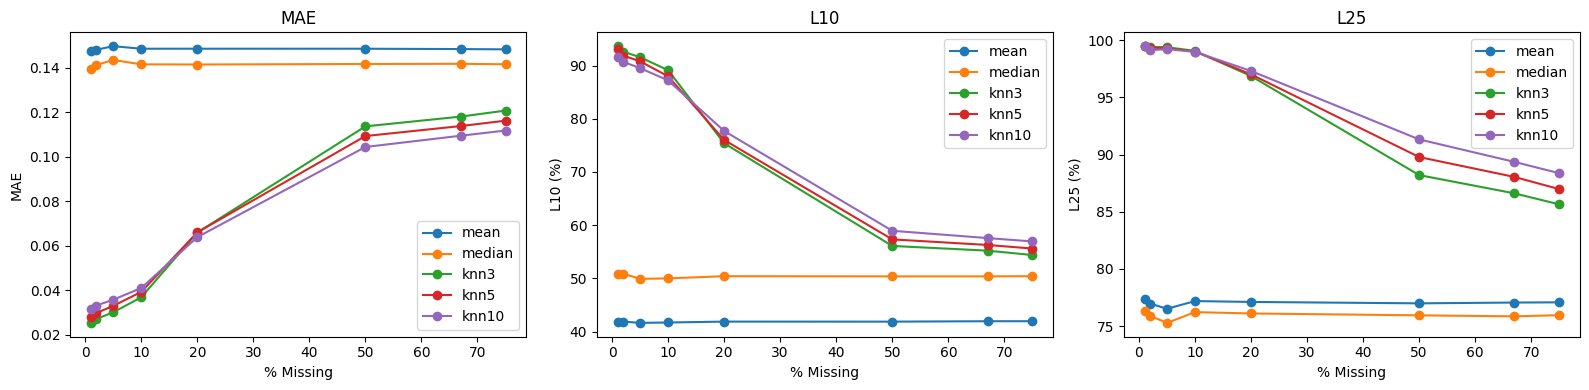

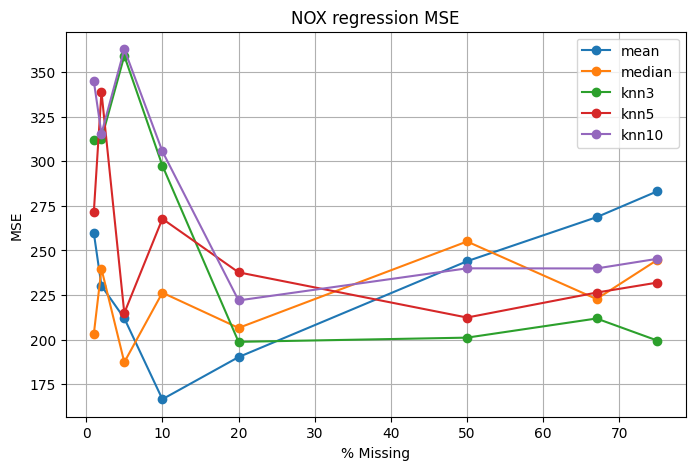

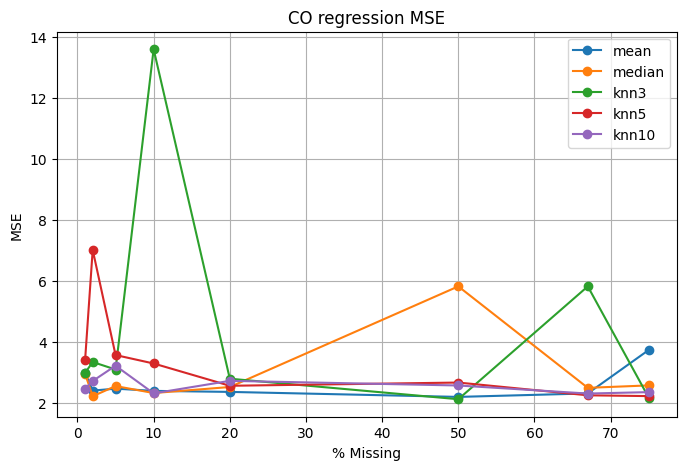

In [16]:
if GT_DF is not None:
    gas_res = gas_turbine_experiments(GT_DF)
    plot_mae_L10_L25(gas_res)
    plot_mse_comparison(gas_res, which='' \
    'nox')
    plot_mse_comparison(gas_res, which='co')


In [35]:
def prsa_experiments(prsa_dict, site_names=None):
    results_by_site = {}
    target_vars = ['SO2','NO2']
    # The paper focused on 10%, 20%, and 50% for MAE/L10/L25 plots (Fig. 6) and 
    # included 1%, 5%, 10%, 20%, 50%, 67%, 75% for MSE plots (Fig. 7, 8)
    fractions = [0.10,0.20,0.50]

    if site_names is None:
        site_names = list(prsa_dict.keys())[:2]
    for site in site_names[0:1]:
        df = prsa_dict[site].copy()
        print('\n=== Site:', site, '===')
        # identify numeric columns and target presence
        df_cols = [c for c in df.columns]
        # try to find exact 'SO2' 'NO2' names (case-insensitive)
        colmap = {c.lower():c for c in df_cols}
        found_targets = [colmap.get(v.lower()) for v in target_vars if colmap.get(v.lower())]
        if len(found_targets) < 2:
            # fallback: try some common names
            fallbacks = [c for c in df_cols if any(k in c.lower() for k in ['so2','no2'])]
            if len(fallbacks) >= 2:
                found_targets = fallbacks[:2]
            else:
                raise RuntimeError('Could not find SO2/NO2 columns in site', site)
        tSO2, tNO2 = found_targets[0], found_targets[1]
        # features: numeric columns excluding year/month/day/hour/station and targets
        exclude = set([tSO2, tNO2, 'station', 'stationid', 'year', 'month','day','hour'])
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        features = [c for c in numeric_cols if c not in exclude]
        print('features detected:', features[:8], '...')

        # **FIX:** To create the "Non-Missing" baseline test set and clean training 
        # set (as implied by the paper for regression evaluation ), 
        # we drop all rows with NaNs in features OR targets before splitting.
        all_cols_for_completeness = features + [tSO2, tNO2]
        df_clean = df.dropna(subset=all_cols_for_completeness, how='any').copy()
        # ----------------------------------------------------------------------

        # train/test split 80/20 random as in paper 
        train_df, test_df = train_test_split(df_clean, test_size=0.2, random_state=RND)
        
        # Reset index after split to ensure alignment
        train_df = train_df.reset_index(drop=True)
        test_df = test_df.reset_index(drop=True)

        scaler = MinMaxScaler()
        scaler.fit(train_df[features])
        
        # The test set is now complete (Non-Missing) for both features and targets.
        X_test_scaled = scaler.transform(test_df[features])
        y_test_so2 = test_df[tSO2].values
        y_test_no2 = test_df[tNO2].values

        # MSE baseline for the 'Non-Missing' test set
        non_missing_mse_so2 = train_evaluate_regression(
            scaler.transform(train_df[features]), train_df[tSO2].values, X_test_scaled, y_test_so2, model_name='mlp'
        )
        non_missing_mse_no2 = train_evaluate_regression(
            scaler.transform(train_df[features]), train_df[tNO2].values, X_test_scaled, y_test_no2, model_name='mlp'
        )

        # we'll run MCAR experiments similar to paper
        res = {'mae':{}, 'L10':{}, 'L25':{}, 'mse_so2':{}, 'mse_no2':{}}
        for frac in fractions:
            print('site',site,'frac',frac)
            # Create MCAR in the features of the *complete* training set
            train_missing, mask = introduce_mcar_per_feature(train_df[features], missing_fraction=frac, copy=True)
            
            # The imputed training set uses the original targets (which are clean)
            train_missing_full = pd.concat([train_missing, train_df[[tSO2,tNO2]]], axis=1)
            
            # compute imputed metrics for methods (mean, median, knn3/5/10)
            for label, method in [('mean','mean'),('median','median'),('knn3',('knn',3)),('knn5',('knn',5)),('knn10',('knn',10))]:
                if isinstance(method, tuple):
                    imputed = apply_imputation(train_missing_full, method='knn', k=method[1])
                else:
                    imputed = apply_imputation(train_missing_full, method=method)
                
                # compute imputation metrics (MAE, L10, L25)
                # NOTE: The paper states imputation metrics are obtained for 10%, 20% and 50% missingness 
                imputed_scaled = pd.DataFrame(scaler.transform(imputed[features]), columns=features, index=train_df.index)
                orig_scaled = pd.DataFrame(scaler.transform(train_df[features]), columns=features, index=train_df.index)
                m, L10, L25 = imputation_metrics(orig_scaled, imputed_scaled, mask)
                res['mae'].setdefault(label,[]).append(m)
                res['L10'].setdefault(label,[]).append(L10)
                res['L25'].setdefault(label,[]).append(L25)
                
                # train MLP and test
                X_train_scaled = scaler.transform(imputed[features])
                
                # Use the clean/non-missing test set for prediction 
                mse_so2 = train_evaluate_regression(X_train_scaled, imputed[tSO2].values, X_test_scaled, y_test_so2, model_name='mlp')
                mse_no2 = train_evaluate_regression(X_train_scaled, imputed[tNO2].values, X_test_scaled, y_test_no2, model_name='mlp')
                
                res['mse_so2'].setdefault(label,[]).append(mse_so2)
                res['mse_no2'].setdefault(label,[]).append(mse_no2)
                print(label, 'MAE', m, 'MSE_SO2', mse_so2, 'MSE_NO2', mse_no2)
            
            # Add the MSE baseline of the non-missing test set for this fraction's column
            res['mse_so2'].setdefault('Non-Missing', []).append(non_missing_mse_so2)
            res['mse_no2'].setdefault('Non-Missing', []).append(non_missing_mse_no2)
            
        # The paper also deletes instances with missing features to obtain a 'missing-deleted' set [cite: 259]
        # This requires re-running the split for each 'missing-deleted' set, but for simplicity/run-time, 
        # we'll implement the 'Delete' experiment using the original logic of dropping rows in the train_df
        # before running the regression model for each fraction.
        
        # Calculate 'Delete' MSE for each fraction
        for frac in fractions:
            train_delete_df = train_df[features].copy()
            # Introduce missingness and then drop rows with *any* missing features
            train_missing_temp, _ = introduce_mcar_per_feature(train_delete_df, missing_fraction=frac, copy=True)
            # Find indices to keep (rows without NaNs after introducing missingness)
            valid_indices = train_missing_temp.dropna(how='any').index
            
            # Filter the training features and targets
            X_train_delete = train_df.loc[valid_indices, features]
            y_train_so2_delete = train_df.loc[valid_indices, tSO2].values
            y_train_no2_delete = train_df.loc[valid_indices, tNO2].values
            
            # Scale the filtered features
            X_train_scaled_delete = scaler.transform(X_train_delete)
            
            # Train and evaluate the 'Delete' model
            mse_so2_delete = train_evaluate_regression(X_train_scaled_delete, y_train_so2_delete, X_test_scaled, y_test_so2, model_name='mlp')
            mse_no2_delete = train_evaluate_regression(X_train_scaled_delete, y_train_no2_delete, X_test_scaled, y_test_no2, model_name='mlp')

            # Append the 'Delete' results
            res['mse_so2'].setdefault('Delete', []).append(mse_so2_delete)
            res['mse_no2'].setdefault('Delete', []).append(mse_no2_delete)
            
        results_by_site[site] = (res, fractions, features, (tSO2,tNO2), scaler, train_df, test_df)
    return results_by_site


=== Site: Aotizhongxin ===
features detected: ['No', 'PM2.5', 'PM10', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP'] ...
site Aotizhongxin frac 0.1
mean MAE 0.1206701462751949 MSE_SO2 119.56485577949086 MSE_NO2 322.0670441262778
median MAE 0.11825245779121699 MSE_SO2 123.71989311126435 MSE_NO2 298.09036540666267
knn3 MAE 0.061571982844307524 MSE_SO2 109.11109194622165 MSE_NO2 271.2380608838865
knn5 MAE 0.0613878851637894 MSE_SO2 109.03669075049012 MSE_NO2 257.3885927803267
knn10 MAE 0.06308411509322487 MSE_SO2 112.74691027833305 MSE_NO2 286.73415423570583
site Aotizhongxin frac 0.2
mean MAE 0.1201080492907387 MSE_SO2 141.23233003482235 MSE_NO2 336.98739611308764
median MAE 0.11766831703547054 MSE_SO2 145.1066666746046 MSE_NO2 324.0886948665454
knn3 MAE 0.06937531821095148 MSE_SO2 114.23485467707872 MSE_NO2 267.1834661876923
knn5 MAE 0.06705513321658257 MSE_SO2 116.79492877958704 MSE_NO2 276.5215405945954
knn10 MAE 0.06639584968111861 MSE_SO2 112.11449874172148 MSE_NO2 291.3990300444431
site Aoti

C:\Users\Himanshu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Himanshu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


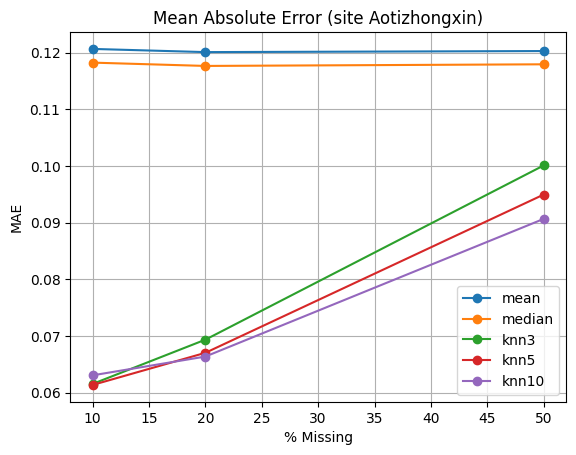

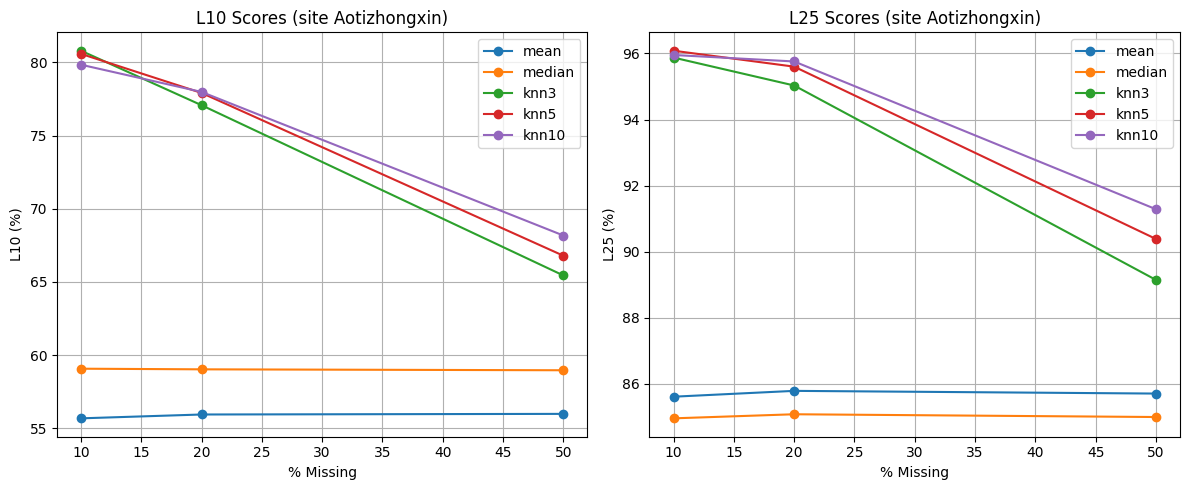

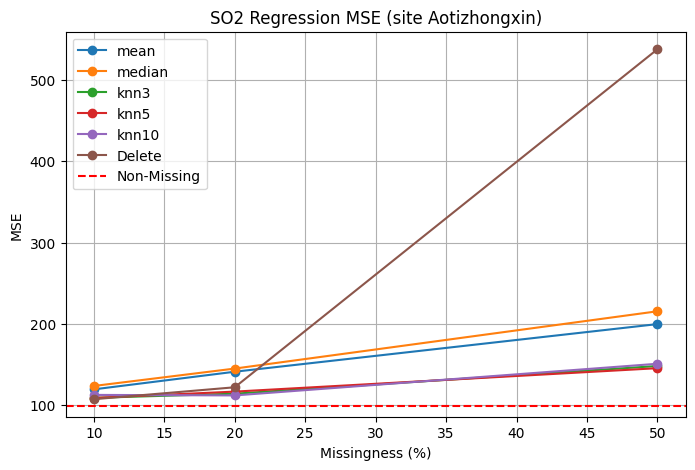

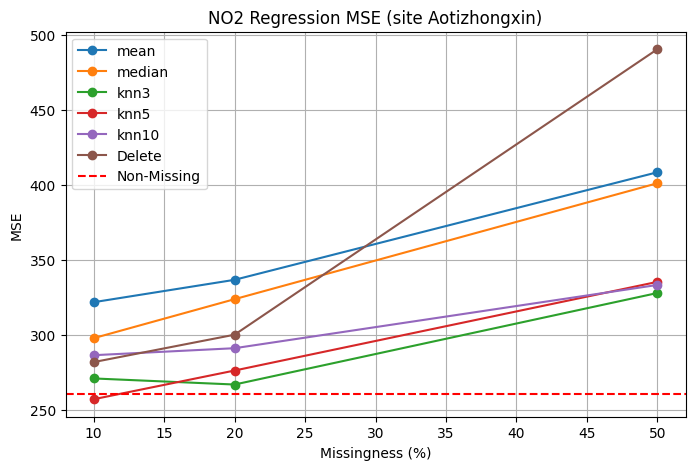

In [36]:
if PRSA_DICT:
    site_keys = list(PRSA_DICT.keys())[:2]
    prsa_results = prsa_experiments(PRSA_DICT, site_names=site_keys)
    

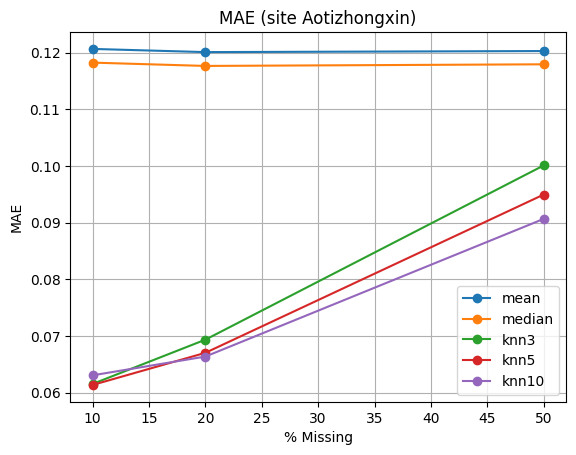

In [37]:
site = site_keys[0]
res, fractions, features, targets, scaler, train_df, test_df = prsa_results[site]
# basic MAE plot
mae_df = pd.DataFrame(res['mae'], index=[int(f*100) for f in fractions])
mae_df.plot(marker='o', title=f'MAE (site {site})')
plt.xlabel('% Missing')
plt.ylabel('MAE')
plt.grid(True)
plt.show()

In [52]:
def prsa_mnar_demo(prsa_dict, site_name=None, thresholds=[0.95,0.9,0.85,0.8,0.75,0.67,0.5]):
    site = site_name or list(prsa_dict.keys())[0]
    df = prsa_dict[site].copy()
    print('\nMNAR demo for', site)
    cols = df.columns.tolist()
    colmap = {c.lower():c for c in cols}
    if 'so2' in colmap and 'no2' in colmap:
        tSO2 = colmap['so2']; tNO2 = colmap['no2']
    else:
        # Fallback if SO2/NO2 are not found by simple name
        num_cols = df.select_dtypes(include=[np.number]).columns
        if len(num_cols) > 4:
            tSO2, tNO2 = num_cols[2], num_cols[3] # assume 3rd and 4th numeric are targets
            print(f"Warning: Could not find SO2/NO2, falling back to {tSO2}, {tNO2}")
        else:
            raise ValueError(f"Could not find SO2/NO2 columns in site {site}")
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    exclude = set([tSO2,tNO2,'year','month','day','hour','station'])
    features = [c for c in numeric_cols if c not in exclude]
    all_cols_for_completeness = features + [tSO2, tNO2]
    df_clean = df.dropna(subset=all_cols_for_completeness, how='any').copy()
    
    train_df, test_df = train_test_split(df_clean, test_size=0.2, random_state=RND)
    
    scaler = MinMaxScaler()
    scaler.fit(train_df[features])
    X_test_scaled = scaler.transform(test_df[features])
    y_test_so2 = test_df[tSO2].values
    y_test_no2 = test_df[tNO2].values
    
    non_missing_mse_so2 = train_evaluate_regression(
        scaler.transform(train_df[features]), train_df[tSO2].values, X_test_scaled, y_test_so2, model_name='mlp'
    )
    
    records = []
    for thr in thresholds:
        train_mnar, mask = introduce_mnar_threshold(train_df[features], threshold=thr, add_random_frac=0.01)
        train_missing_full = pd.concat([train_mnar.reset_index(drop=True), train_df[[tSO2,tNO2]].reset_index(drop=True)], axis=1)
        im_knn = apply_imputation(train_missing_full, method='knn', k=5)
        im_mean = apply_imputation(train_missing_full, method='mean')
        orig_scaled = pd.DataFrame(scaler.transform(train_df[features]), columns=features)
        knn_scaled = pd.DataFrame(scaler.transform(im_knn[features]), columns=features)
        mean_scaled = pd.DataFrame(scaler.transform(im_mean[features]), columns=features)
        m_knn, L10_knn, L25_knn = imputation_metrics(orig_scaled, knn_scaled, mask.reset_index(drop=True))
        m_mean, L10_mean, L25_mean = imputation_metrics(orig_scaled, mean_scaled, mask.reset_index(drop=True))
        
        X_knn = scaler.transform(im_knn[features])
        X_mean = scaler.transform(im_mean[features])
        
        # Train and Evaluate Regression using the clean X_test_scaled and y_test_so2
        mse_knn_so2 = train_evaluate_regression(X_knn, im_knn[tSO2].values, X_test_scaled, y_test_so2, model_name='mlp')
        mse_mean_so2 = train_evaluate_regression(X_mean, im_mean[tSO2].values, X_test_scaled, y_test_so2, model_name='mlp')
        valid_indices_delete = train_mnar.dropna(how='any').index
        
        X_train_delete = train_df.loc[valid_indices_delete, features]
        y_train_so2_delete = train_df.loc[valid_indices_delete, tSO2].values
        
        X_train_scaled_delete = scaler.transform(X_train_delete)
        
        mse_delete_so2 = train_evaluate_regression(X_train_scaled_delete, y_train_so2_delete, X_test_scaled, y_test_so2, model_name='mlp')

        
        records.append({
            'threshold': thr, 
            'm_knn': m_knn, 
            'm_mean': m_mean, 
            'mse_knn_so2': mse_knn_so2, 
            'mse_mean_so2': mse_mean_so2,
            'mse_delete_so2': mse_delete_so2,
            'mse_non_missing_so2': non_missing_mse_so2 # Include baseline for plotting/printing
        })
        
        print(f'thr {thr} m_knn {m_knn} m_mean {m_mean} mse_knn_so2 {mse_knn_so2} mse_mean_so2 {mse_mean_so2} mse_delete_so2 {mse_delete_so2}')
        
    return records


In [54]:
if PRSA_DICT:
    site = list(PRSA_DICT.keys())[0]
    recs = prsa_mnar_demo(PRSA_DICT, site_name=site)


MNAR demo for Aotizhongxin
thr 0.95 m_knn 0.18787831856101408 m_mean 0.26155311682303817 mse_knn_so2 106.40493271719033 mse_mean_so2 109.24595219500695 mse_delete_so2 107.24079940787422
thr 0.9 m_knn 0.2628522246959026 m_mean 0.32261359399607537 mse_knn_so2 114.59946504208176 mse_mean_so2 115.9495179058682 mse_delete_so2 104.84891163623371
thr 0.85 m_knn 0.22960831255021594 m_mean 0.34869899579393343 mse_knn_so2 127.94650016096311 mse_mean_so2 130.11613292888683 mse_delete_so2 112.47920733751836
thr 0.8 m_knn 0.2359113788363065 m_mean 0.36199596833568665 mse_knn_so2 127.09007669868404 mse_mean_so2 138.78992302264416 mse_delete_so2 113.50492613358067
thr 0.75 m_knn 0.2618416892946046 m_mean 0.3682987405004597 mse_knn_so2 161.70516487443408 mse_mean_so2 164.17738231178322 mse_delete_so2 119.89696142235275
thr 0.67 m_knn 0.3051038831107031 m_mean 0.37366465170901453 mse_knn_so2 176.3258605312717 mse_mean_so2 175.9693874620678 mse_delete_so2 152.09022902493402
thr 0.5 m_knn 0.340398179099

C:\Users\Himanshu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [55]:
def autism_experiments(df_arff):
    # try to detect class column
    cols = list(df_arff.columns)
    print('Autism columns:', cols)
    class_candidates = [c for c in cols if 'class' in c.lower() or 'asd' in c.lower()]
    if class_candidates:
        class_col = class_candidates[0]
    else:
        class_col = cols[-1]
    # identify categorical features: object dtype or few unique values
    cat_cols = [c for c in cols if df_arff[c].dtype == object or df_arff[c].nunique() < 20]
    cat_cols = [c for c in cat_cols if c != class_col]
    num_cols = [c for c in cols if c not in cat_cols + [class_col]]
    print('class col', class_col, 'categorical cols', cat_cols)

    # drop rows with missing class
    df = df_arff.dropna(subset=[class_col]).reset_index(drop=True)
    # convert binary labels to 0/1 if needed
    if df[class_col].dtype == object:
        le = LabelEncoder(); df[class_col] = le.fit_transform(df[class_col])
    # split: separate rows with any missing value and rows without
    rows_missing_any = df[df.isnull().any(axis=1)]
    rows_complete = df[~df.isnull().any(axis=1)]
    # test: 20% of complete rows
    test = rows_complete.sample(frac=0.2, random_state=RND)
    remaining_complete = rows_complete.drop(test.index)
    # validation: 20% of remaining_complete
    val = remaining_complete.sample(frac=0.2, random_state=RND)
    ground_truth = remaining_complete.drop(val.index)

    # training set is ground_truth + rows_missing_any
    train_initial = pd.concat([ground_truth, rows_missing_any], ignore_index=True)
    print('sizes: train', len(train_initial), 'val', len(val), 'test', len(test))

    # prepare features X and label y
    features = [c for c in df.columns if c != class_col]

    # function to run imputation method and evaluate with SVC (AUC)
    def run_and_eval(train_df, test_df, impute_method='most_frequent', k=5):
        # encode categorical columns into numeric (simple label encoding per column)
        train_enc = train_df.copy()
        test_enc = test_df.copy()
        encoders = {}
        for c in cat_cols:
            le = LabelEncoder()
            # fit on all seen values
            vals = pd.concat([train_enc[c].astype(str), test_enc[c].astype(str)], axis=0).unique()
            le.fit(vals)
            # transform but allow NaN - replace NaN with a placeholder string
            train_enc[c] = train_enc[c].astype(str).fillna('___nan___')
            test_enc[c] = test_enc[c].astype(str).fillna('___nan___')
            train_enc[c] = le.transform(train_enc[c])
            test_enc[c] = le.transform(test_enc[c])
            encoders[c] = le
        # numeric columns: fill NA remain as-is for imputer
        # apply imputation on full training table of features
        to_impute = train_enc[features].copy()
        if impute_method=='knn':
            imp = KNNImputer(n_neighbors=k)
            imputed_vals = imp.fit_transform(to_impute)
        else:
            imp = SimpleImputer(strategy='most_frequent')
            imputed_vals = imp.fit_transform(to_impute)
        X_train = pd.DataFrame(imputed_vals, columns=features)
        y_train = train_df[class_col].values
        # prepare test (we will impute test using the same imputer)
        to_impute_test = test_enc[features].copy()
        test_imputed_vals = imp.transform(to_impute_test)
        X_test = pd.DataFrame(test_imputed_vals, columns=features)
        y_test = test_df[class_col].values
        auc, fpr, tpr = train_evaluate_classification(X_train, y_train, X_test, y_test, model_name='svc')
        return auc, fpr, tpr
    
    # evaluate mode and knn on original missingness
    auc_mode, fpr_mode, tpr_mode = run_and_eval(train_initial, test, impute_method='most_frequent')
    auc_knn, fpr_knn, tpr_knn = run_and_eval(train_initial, test, impute_method='knn', k=5)
    print('Original missingness: AUC mode', auc_mode, 'AUC knn', auc_knn)

    # create a 10% missingness dataset by deleting categorical entries at random
    train_with_extra = train_initial.copy()
    # pick 10% of entries in categorical features to set NaN
    total_entries = train_with_extra[cat_cols].size
    k = int(0.10 * total_entries)
    rows = np.random.choice(train_with_extra.index, size=k, replace=True)
    cols = np.random.choice(cat_cols, size=k, replace=True)
    for r,c in zip(rows, cols):
        train_with_extra.at[r,c] = np.nan

    auc_mode_10, fpr_m_10, tpr_m_10 = run_and_eval(train_with_extra, test, impute_method='most_frequent')
    auc_knn_10, fpr_k_10, tpr_k_10 = run_and_eval(train_with_extra, test, impute_method='knn', k=5)
    print('10% extra missingness: AUC mode', auc_mode_10, 'AUC knn', auc_knn_10)

    # return ROC data to plot similar to paper
    return {
        'original': {'mode':(auc_mode,fpr_mode,tpr_mode), 'knn':(auc_knn,fpr_knn,tpr_knn)},
        'extra10': {'mode':(auc_mode_10,fpr_m_10,tpr_m_10), 'knn':(auc_knn_10,fpr_k_10,tpr_k_10)},
        'sizes': {'train':len(train_initial),'val':len(val),'test':len(test)}
    }

In [56]:
if AUTISM_DF is not None:
    autism_res = autism_experiments(AUTISM_DF)
    print(autism_res)

Autism columns: ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender', 'ethnicity', 'jundice', 'austim', 'contry_of_res', 'used_app_before', 'result', 'age_desc', 'relation', 'Class/ASD']
class col Class/ASD categorical cols ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'gender', 'ethnicity', 'jundice', 'austim', 'contry_of_res', 'used_app_before', 'result', 'age_desc', 'relation']
sizes: train 452 val 112 test 140
Original missingness: AUC mode 0.8542222222222222 AUC knn 0.8542222222222222
10% extra missingness: AUC mode 0.8963333333333333 AUC knn 0.8975555555555557
{'original': {'mode': (0.8542222222222222, array([0.        , 0.        , 0.        , 0.01111111, 0.01111111,
       0.02222222, 0.02222222, 0.03333333, 0.03333333, 0.07777778,
       0.07777778, 0.1       , 0.1       , 0.14444444, 0.14444444,
       0.21111111, 0.2

In [57]:
# %%
# Plot ROC curves for original missingness and 10% extra missingness
def plot_autism_roc(roc_results):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,6))
    
    # Original missingness
    auc_mode, fpr_mode, tpr_mode = roc_results['original']['mode']
    auc_knn, fpr_knn, tpr_knn = roc_results['original']['knn']
    plt.plot(fpr_mode, tpr_mode, label=f'Mode (original) AUC={auc_mode:.3f}', lw=2)
    plt.plot(fpr_knn, tpr_knn, label=f'KNN (original) AUC={auc_knn:.3f}', lw=2)
    
    # 10% extra missingness
    auc_mode_10, fpr_m_10, tpr_m_10 = roc_results['extra10']['mode']
    auc_knn_10, fpr_k_10, tpr_k_10 = roc_results['extra10']['knn']
    plt.plot(fpr_m_10, tpr_m_10, '--', label=f'Mode +10% missing AUC={auc_mode_10:.3f}', lw=2)
    plt.plot(fpr_k_10, tpr_k_10, '--', label=f'KNN +10% missing AUC={auc_knn_10:.3f}', lw=2)

    plt.plot([0,1],[0,1],'k--', lw=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Autism Dataset: ROC curves for Imputation Methods')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

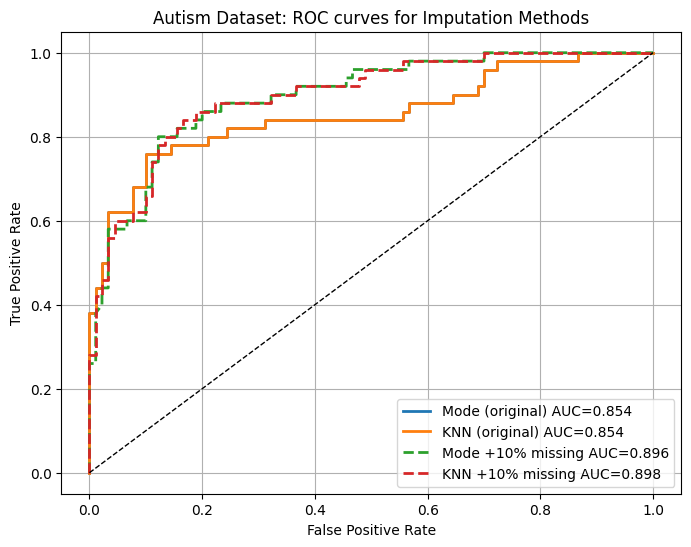

In [58]:


plot_autism_roc(autism_res)


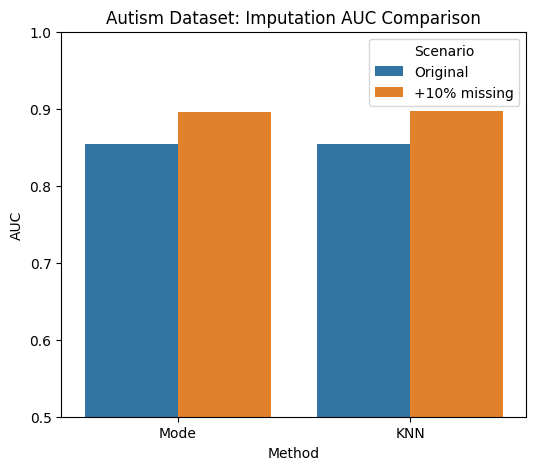

In [59]:
# %%
# Optional: Bar plot comparing AUCs
def plot_autism_auc_bar(roc_results):
    import seaborn as sns
    import pandas as pd
    
    df_plot = pd.DataFrame({
        'Method': ['Mode','KNN','Mode','KNN'],
        'Scenario': ['Original','Original','+10% missing','+10% missing'],
        'AUC': [
            roc_results['original']['mode'][0],
            roc_results['original']['knn'][0],
            roc_results['extra10']['mode'][0],
            roc_results['extra10']['knn'][0]
        ]
    })
    plt.figure(figsize=(6,5))
    sns.barplot(x='Method', y='AUC', hue='Scenario', data=df_plot)
    plt.ylim(0.5,1.0)
    plt.title('Autism Dataset: Imputation AUC Comparison')
    plt.show()

plot_autism_auc_bar(autism_res)


In [60]:
# %%
# Print simple conclusions
def autism_conclusions(roc_results):
    print("=== Autism Dataset Imputation Conclusions ===\n")
    orig_mode_auc = roc_results['original']['mode'][0]
    orig_knn_auc = roc_results['original']['knn'][0]
    extra_mode_auc = roc_results['extra10']['mode'][0]
    extra_knn_auc = roc_results['extra10']['knn'][0]

    print(f"Original missingness: Mode AUC = {orig_mode_auc:.3f}, KNN AUC = {orig_knn_auc:.3f}")
    print(f"10% extra missingness: Mode AUC = {extra_mode_auc:.3f}, KNN AUC = {extra_knn_auc:.3f}\n")

    if orig_knn_auc > orig_mode_auc:
        print("=> KNN slightly outperforms Mode imputation on original missing data.")
    else:
        print("=> Mode imputation performs similar or better than KNN on original missing data.")
    
    if extra_knn_auc > extra_mode_auc:
        print("=> KNN is more robust to additional 10% missingness than Mode.")
    else:
        print("=> Mode imputation degrades faster than KNN with added missingness.")

autism_conclusions(autism_res)


=== Autism Dataset Imputation Conclusions ===

Original missingness: Mode AUC = 0.854, KNN AUC = 0.854
10% extra missingness: Mode AUC = 0.896, KNN AUC = 0.898

=> Mode imputation performs similar or better than KNN on original missing data.
=> KNN is more robust to additional 10% missingness than Mode.
